# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import pandas as pd
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-15 00:45:07,704 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv"
)

dt_prophet_holidays = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

In [4]:
from robyn.tutorials.utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Debug: R output data keys: ['trial1', 'trial2', 'trial3', 'trial4', 'trial5']
Data for trial1: Keys = ['resultCollect', 'hyperBoundNG', 'hyperBoundFixed']
Debug: resultCollect keys for trial1: ['resultHypParam', 'xDecompAgg', 'decompSpendDist', 'iter', 'elapsed.min']
Debug: Sample resultHypParam for trial1: [{'facebook_S_alphas': 1.98202923325, 'facebook_S_gammas': 0.58424338159, 'facebook_S_thetas': 0.09072730547999999, 'newsletter_alphas': 1.7514167265, 'newsletter_gammas': 0.6585122811199999, 'newsletter_thetas': 0.22826231587, 'ooh_S_alphas': 1.9350874957500002, 'ooh_S_gammas': 0.80499137605, 'ooh_S_thetas': 0.26847073588000003, 'print_S_alphas': 1.3471347205000002, 'print_S_gammas': 0.6602001640299999, 'print_S_thetas': 0.34398200833000003, 'search_S_alphas': 1.835435262, 'search_S_gammas': 0.6915214566899999, 'search_S_thetas': 0.1125

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [5]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [6]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [7]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [8]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-15 00:45:09,555 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-15 00:45:09,557 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-15 00:45:09,557 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-15 00:45:10,316 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpdmxps5oi/fol8s_9o.json
2024-11-15 00:45:10,325 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

All ind vars ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']


2024-11-15 00:45:10,540 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-15 00:45:10,541 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-15 00:45:10,666 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


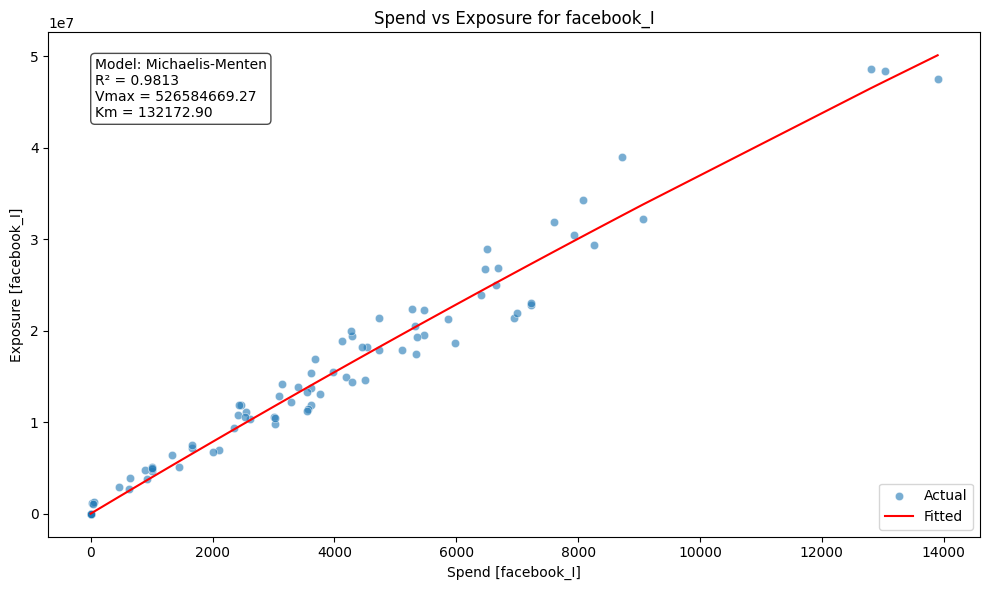

2024-11-15 00:45:10,766 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-15 00:45:10,921 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


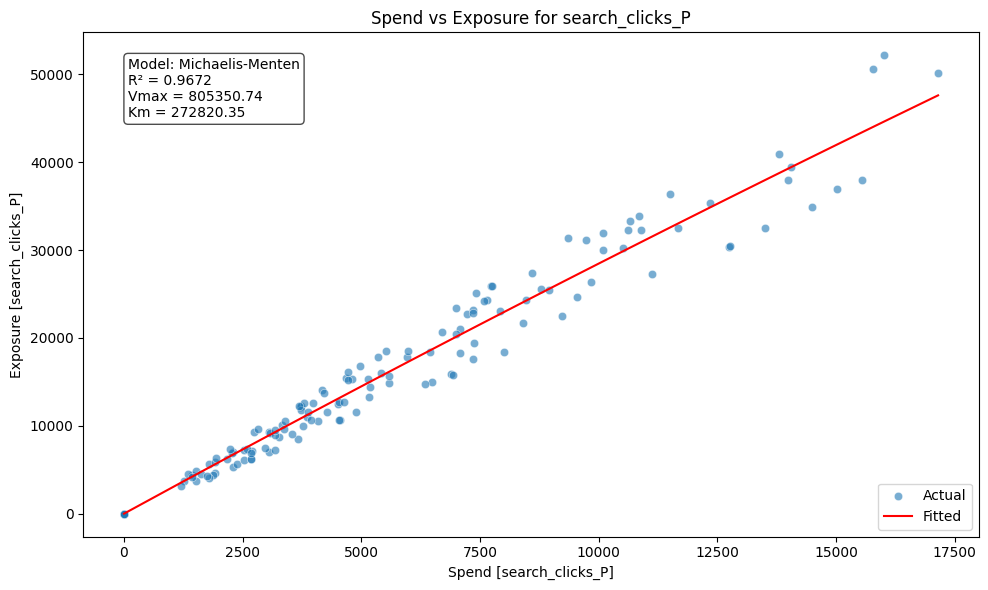

In [9]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-15 00:45:11,029 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-15 00:45:11,030 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-15 00:45:11,030 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-15 00:45:11,030 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-15 00:45:11,031 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-15 00:45:11,031 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-15 00:45:11,031 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-15 00:45:11,032 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:45:16,441 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:45:21,817 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:45:27,394 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:45:32,811 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 00:45:38,293 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
2024-11-15 00:45:38,300 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-15 00:45:38,300 - robyn.

Model training complete.


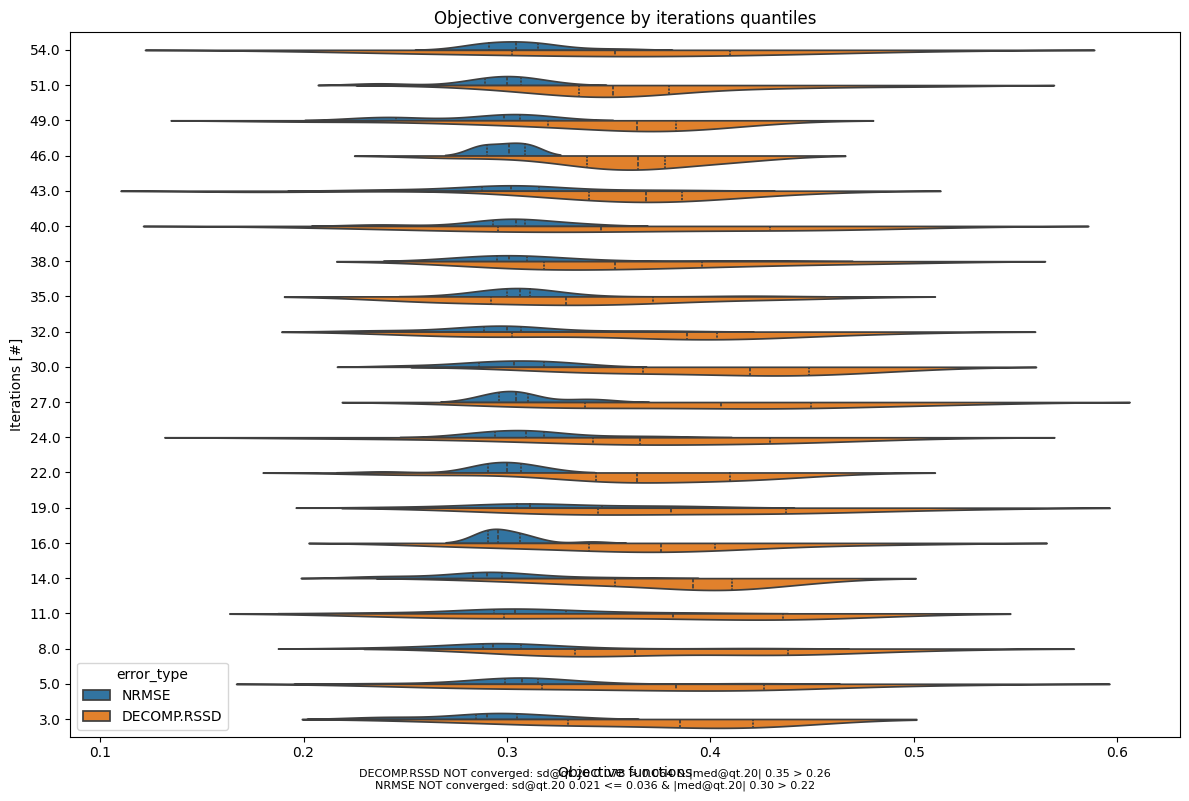

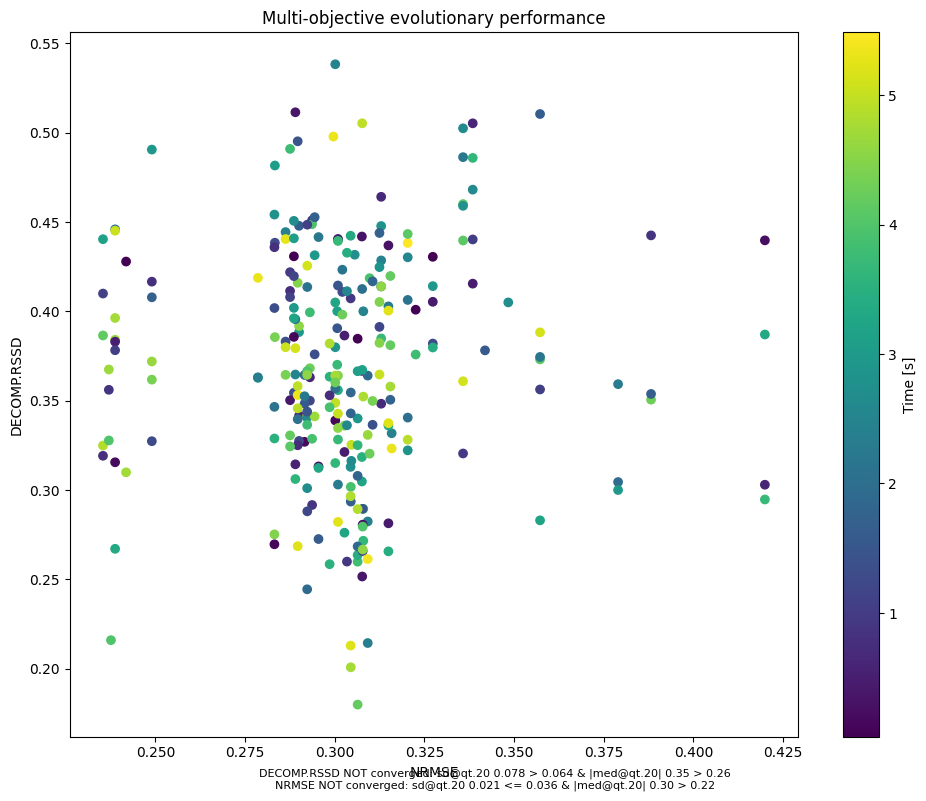

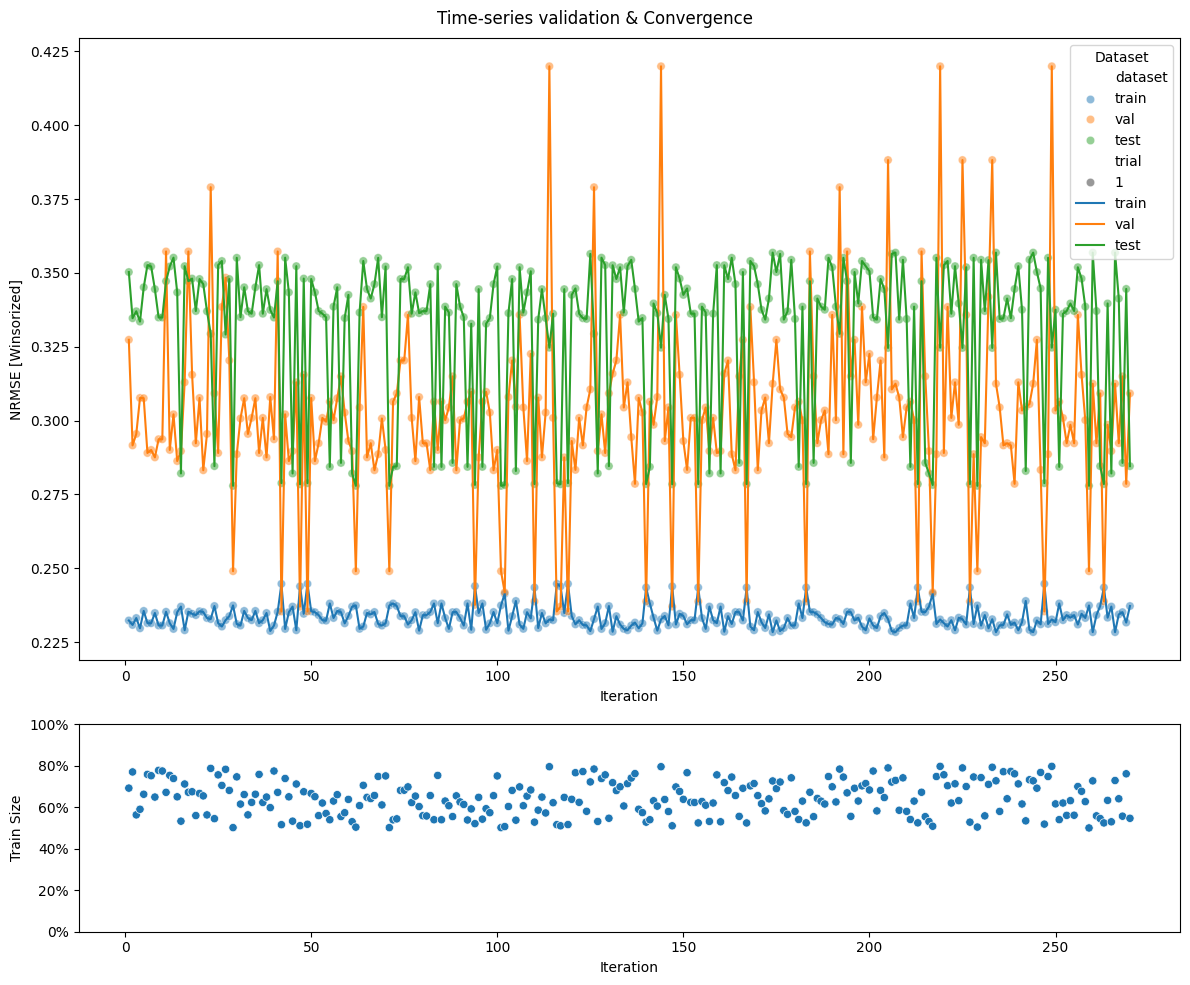

In [10]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=54, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [11]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 2_1_1


In [12]:
# Add after model training
print("Model Output Summary:")
print(f"Number of trials: {len(output_models.trials)}")
print(f"Average models per trial: {len(output_models.all_result_hyp_param) / len(output_models.trials)}")
print(f"Total unique models: {len(output_models.all_result_hyp_param['sol_id'].unique())}")

print("\nMetrics Distribution:")
metrics_df = output_models.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
print(metrics_df.describe())

# Additional validation to debug model output
print("\nColumns in result_hyp_param:")
print(output_models.all_result_hyp_param.columns.tolist())

print("\nSample rows of metrics:")
print(output_models.all_result_hyp_param[["sol_id", "nrmse", "decomp.rssd", "mape"]].head())

# Show shape of result dataframes
print("\nDataFrame Shapes:")
print(f"result_hyp_param: {output_models.all_result_hyp_param.shape}")
print(f"x_decomp_agg: {output_models.all_x_decomp_agg.shape}")
print(f"decomp_spend_dist: {output_models.all_decomp_spend_dist.shape}")

Model Output Summary:
Number of trials: 5
Average models per trial: 54.0
Total unique models: 270

Metrics Distribution:
            nrmse  decomp.rssd   mape
count  270.000000   270.000000  270.0
mean     0.302040     0.368954    0.0
std      0.030736     0.063796    0.0
min      0.235413     0.179811    0.0
25%      0.289696     0.327317    0.0
50%      0.300926     0.364911    0.0
75%      0.312495     0.414367    0.0
max      0.419955     0.538310    0.0

Columns in result_hyp_param:
['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas', 'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas', 'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'lambda', 'train_size', 'sol_id', 'Elapsed', 'ElapsedAccum', 'pos', 'trial', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'decomp.rssd

In [24]:
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(mmm_data, r_output_models, r_hyperparameters, featurized_mmm_data, holidays_data)

In [26]:
# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2024-11-15 00:47:55 [INFO] Starting Pareto optimization
2024-11-15 00:47:55 [INFO] Starting model data aggregation
2024-11-15 00:47:55 [INFO] Computing Pareto fronts
2024-11-15 00:47:55 [INFO] Pareto front computation completed
2024-11-15 00:47:55 [INFO] Preparing Pareto data
2024-11-15 00:47:55 [INFO] Number of Pareto-optimal solutions found: 217
2024-11-15 00:47:55 [INFO] Selected 10 Pareto-fronts containing 108 candidates
2024-11-15 00:47:55 [INFO] Filtering data for selected Pareto fronts...
2024-11-15 00:47:55 [INFO] Calculating response curves for 540 models' media variables...
Processing rows: 100%|██████████| 540/540 [00:05<00:00, 94.55it/s] 
2024-11-15 00:48:02 [INFO] Successfully processed 540 response curves
2024-11-15 00:48:02 [INFO] Computing final metrics...
2024-11-15 00:48:02 [INFO] Calculating ROI and CPA metrics...
2024-11-15 00:48:02 [INFO] Starting plot data generation...
2024-11-15 00:48:02 [INFO] Processing Pareto front 1
2024-11-15 00:48:02 [INFO] Pareto-Front: 1

In [27]:
# 5. Check results
print("Pareto Optimization Results:")
print(f"Number of Pareto fronts: {pareto_result.pareto_solutions}")
print(f"MediaVecCollect: {pareto_result.media_vec_collect.shape, pareto_result.media_vec_collect}")
print("\Hyper parameter solutions:")
print(pareto_result.result_hyp_param)

print("\nAggregated decomposition results:")
print(pareto_result.x_decomp_agg)
print("\result Calibration:")
print(pareto_result.result_calibration)
print("\nx Decomp Vec Collect:")
print(pareto_result.x_decomp_vec_collect.shape, pareto_result.x_decomp_vec_collect)
print("\nCarryover percentage all:")
print(pareto_result.df_caov_pct_all.shape, pareto_result.df_caov_pct_all)
print("\Plot Data Collected")
print("NUMBER OF PLOTS Data collected for:", len(pareto_result.plot_data_collect))
print("Plot data for solid 5_221_9", pareto_result.plot_data_collect)

# 6. Validate logic
assert pareto_result.pareto_fronts == "auto" or isinstance(
    pareto_result.pareto_fronts, int
), "Invalid pareto_fronts value"
assert not pareto_result.result_hyp_param.empty, "Empty result_hyp_param DataFrame"
assert not pareto_result.x_decomp_agg.empty, "Empty x_decomp_agg DataFrame"

print("\nAll assertions passed. The optimize function is working as expected.")

Pareto Optimization Results:
Number of Pareto fronts: {nan, '2_1_5', '1_5_3', '3_2_5', '3_3_6', '1_3_1', '2_4_9', '3_2_1', '1_5_5', '3_4_1', '1_6_1', '5_5_5', '1_2_4', '5_4_9', '5_4_8', '2_1_3', '4_4_2', '1_6_8', '3_6_9', '5_6_7', '2_6_2', '5_4_6', '1_4_2', '2_5_2', '3_2_8', '3_6_2', '5_4_3', '3_6_1', '2_4_1', '3_5_8', '5_1_6', '1_3_8', '2_5_7', '2_1_1', '3_1_6', '3_5_1', '3_3_5', '1_3_7', '2_6_9', '4_5_8', '3_4_5', '3_1_3', '2_1_4', '4_6_9', '5_4_7', '3_4_6', '3_2_2', '3_6_7', '3_4_2', '2_4_8', '4_2_7', '5_3_4', '4_4_5', '4_5_2', '4_5_5', '3_1_4', '2_4_4', '2_5_8', '5_6_8', '5_1_8', '3_6_8', '1_6_7', '4_3_5', '2_6_4', '2_6_7', '5_6_5', '1_3_4', '2_2_4', '4_4_3', '4_6_5', '4_1_3', '1_6_6', '3_6_3', '5_6_6', '5_6_2', '1_2_7', '4_1_2', '1_3_3', '3_5_4', '3_4_7', '4_4_6', '2_4_7', '4_3_9', '3_5_9', '1_5_2', '2_6_8', '4_3_6', '1_1_9', '3_6_4', '2_1_8', '5_5_1', '2_6_5', '3_4_3', '3_5_2', '4_4_4', '3_2_6', '3_1_2', '4_6_8', '1_5_1', '1_1_5', '5_5_7', '3_2_7', '4_3_8', '5_1_3', '2_4_2', '4_2

In [28]:
len(pareto_result.pareto_solutions)

109

## Allocator

In [29]:
## Step 1: Setup and Import

# Import necessary Robyn classes
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode
from robyn.allocator.budget_allocator import BudgetAllocator
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from robyn.visualization.allocator_plotter import AllocationPlotter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
print(pareto_result.result_hyp_param["sol_id"])

0      1_1_1
1      1_1_2
2      1_1_3
3      1_1_4
4      1_1_5
       ...  
265    5_6_5
266    5_6_6
267    5_6_7
268    5_6_8
269    5_6_9
Name: sol_id, Length: 270, dtype: object


In [31]:
# Make sure to use the correct model ID from your pareto results
available_models = pareto_result.result_hyp_param["sol_id"].unique()  # or 'solID' if that's the column name
print(f"Available models: {available_models}")
# Initialize allocator with a valid model ID
select_model = available_models[0]  # Use first available model

# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    model_outputs=output_models,
    pareto_result=pareto_result,  # Get ParetoResult from import_output_collect()
    select_model=select_model,
)

2024-11-15 00:48:14,148 - robyn.allocator.budget_allocator - INFO - Initializing BudgetAllocator
2024-11-15 00:48:14,149 - robyn.allocator.media_response - INFO - Initializing MediaResponseParamsCalculator
2024-11-15 00:48:14,149 - robyn.allocator.allocation_optimizer - INFO - Initializing AllocationOptimizer
2024-11-15 00:48:14,150 - robyn.allocator.media_response - INFO - Starting media response parameters calculation for model 1_1_1
2024-11-15 00:48:14,154 - robyn.allocator.media_response - INFO - Successfully calculated media response parameters: MediaResponseParameters(alphas=5 channels, inflexions=5 channels, coefficients=5 channels)
2024-11-15 00:48:14,155 - robyn.allocator.budget_allocator - INFO - BudgetAllocator initialization completed successfully


Available models: ['1_1_1' '1_1_2' '1_1_3' '1_1_4' '1_1_5' '1_1_6' '1_1_7' '1_1_8' '1_1_9'
 '1_2_1' '1_2_2' '1_2_3' '1_2_4' '1_2_5' '1_2_6' '1_2_7' '1_2_8' '1_2_9'
 '1_3_1' '1_3_2' '1_3_3' '1_3_4' '1_3_5' '1_3_6' '1_3_7' '1_3_8' '1_3_9'
 '1_4_1' '1_4_2' '1_4_3' '1_4_4' '1_4_5' '1_4_6' '1_4_7' '1_4_8' '1_4_9'
 '1_5_1' '1_5_2' '1_5_3' '1_5_4' '1_5_5' '1_5_6' '1_5_7' '1_5_8' '1_5_9'
 '1_6_1' '1_6_2' '1_6_3' '1_6_4' '1_6_5' '1_6_6' '1_6_7' '1_6_8' '1_6_9'
 '2_1_1' '2_1_2' '2_1_3' '2_1_4' '2_1_5' '2_1_6' '2_1_7' '2_1_8' '2_1_9'
 '2_2_1' '2_2_2' '2_2_3' '2_2_4' '2_2_5' '2_2_6' '2_2_7' '2_2_8' '2_2_9'
 '2_3_1' '2_3_2' '2_3_3' '2_3_4' '2_3_5' '2_3_6' '2_3_7' '2_3_8' '2_3_9'
 '2_4_1' '2_4_2' '2_4_3' '2_4_4' '2_4_5' '2_4_6' '2_4_7' '2_4_8' '2_4_9'
 '2_5_1' '2_5_2' '2_5_3' '2_5_4' '2_5_5' '2_5_6' '2_5_7' '2_5_8' '2_5_9'
 '2_6_1' '2_6_2' '2_6_3' '2_6_4' '2_6_5' '2_6_6' '2_6_7' '2_6_8' '2_6_9'
 '3_1_1' '3_1_2' '3_1_3' '3_1_4' '3_1_5' '3_1_6' '3_1_7' '3_1_8' '3_1_9'
 '3_2_1' '3_2_2' '3_2_3' '3_2_4' 

## Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [32]:
# Create base constraints matching R example
channel_constraints = AllocationConstraints(
    channel_constr_low={
        "tv_S": 0.7,  # -30% from base
        "ooh_S": 0.7,
        "print_S": 0.7,
        "facebook_S": 0.7,
        "search_S": 0.7,
    },
    channel_constr_up={
        "tv_S": 1.2,  # +20% from base
        "ooh_S": 1.5,  # +50% from base
        "print_S": 1.5,
        "facebook_S": 1.5,
        "search_S": 1.5,
    },
    channel_constr_multiplier=3.0,
)

# Configure max response scenario
max_response_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result = allocator.allocate(max_response_config)

# Print results
print(
    f"""
Model ID: {select_model}
Scenario: {max_response_config.scenario}
Use case: {result.metrics.get('use_case', '')}
Window: {result.metrics.get('date_range_start')}:{result.metrics.get('date_range_end')} ({result.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result.metrics.get('spend_lift_pct', 0):.1f}% ({result.metrics.get('spend_lift_abs', 0):+.0f}K)
Total Response Increase (Optimized): {result.metrics.get('response_lift', 0)*100:.1f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result.optimal_allocations[result.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-15 00:48:14,211 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-15 00:48:14,217 - robyn.allocator.budget_allocator - WARNING - Found zero mean spend for channels: ['tv_S' 'ooh_S' 'print_S' 'search_S']
2024-11-15 00:48:14,221 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0668
2024-11-15 00:48:14,222 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0008
2024-11-15 00:48:14,224 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.8458
2024-11-15 00:48:14,225 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -2.8388
2024-11-15 00:48:14,225 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -2.6607
2024-11-15 00:48:14,229 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-15 00:48:14,232 - robyn.allocator.bu


Model ID: 1_1_1
Scenario: max_response
Use case: 
Window: 2019-11-11 00:00:00:2019-11-11 00:00:00 (1 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 0.0% (+0K)
Total Response Increase (Optimized): 5.7%

Allocation Summary:


- tv_S:
  Optimizable bound: [-30%, 20%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.09% -> Optimized bounded: 0.05%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- ooh_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.00% -> Optimized bounded: 0.00%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- print_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 1.50% -> Optimized bounded: 0.89%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- facebook_S:
  Optimizable bound: [-30%, 50%

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [33]:
### Scenario 3: Default Target Efficiency (Target ROAS or CPA)
print("\nScenario 3: Target efficiency optimization")

# Create constraints matching R's implementation
default_channel_constraints = AllocationConstraints(
    channel_constr_low={
        channel: 0.1 for channel in mmm_data.mmmdata_spec.paid_media_spends  # -90% from base for all channels
    },
    channel_constr_up={
        channel: 10.0 for channel in mmm_data.mmmdata_spec.paid_media_spends  # +900% from base for all channels
    },
    channel_constr_multiplier=1.0,  # Don't extend bounds for target efficiency
    is_target_efficiency=True,  # Flag this as target efficiency scenario
)

# Create configuration for target efficiency scenario
target_efficiency_config = AllocationConfig(
    scenario=OptimizationScenario.TARGET_EFFICIENCY,
    constraints=default_channel_constraints,
    date_range="all",  # Use all dates like in R version
    target_value=None,  # Will use default 80% of initial ROAS or 120% of initial CPA
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result3 = allocator.allocate(target_efficiency_config)

# Print results matching R format
print(
    f"""
Model ID: {select_model}
Scenario: {target_efficiency_config.scenario}
Use case: {result3.metrics.get('use_case', '')}
Window: {result3.metrics.get('date_range_start')}:{result3.metrics.get('date_range_end')} ({result3.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result3.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result3.metrics.get('spend_lift_pct', 0):.0f}% ({result3.metrics.get('spend_lift_abs', 0):.0f})
Total Response Increase (Optimized): {result3.metrics.get('response_lift', 0)*100:.0f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result3.optimal_allocations[result3.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-15 00:48:14,318 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-15 00:48:14,321 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.3683
2024-11-15 00:48:14,321 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0209
2024-11-15 00:48:14,322 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -1.0808
2024-11-15 00:48:14,322 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -3.6822
2024-11-15 00:48:14,323 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -6.4603
2024-11-15 00:48:14,323 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-15 00:48:14,324 - robyn.allocator.budget_allocator - INFO - Running optimization for scenario: OptimizationScenario.TARGET_EFFICIENCY
2024-11-15 00:48:14,324 - robyn.allocator.budge


Scenario 3: Target efficiency optimization


2024-11-15 00:48:14,390 - robyn.allocator.allocation_optimizer - INFO - Optimization completed successfully
2024-11-15 00:48:14,391 - robyn.allocator.budget_allocator - INFO - Target efficiency optimization completed successfully
2024-11-15 00:48:14,403 - robyn.allocator.budget_allocator - INFO - Response curves generated successfully
2024-11-15 00:48:14,416 - robyn.allocator.budget_allocator - INFO - Response curves generated successfully
2024-11-15 00:48:14,417 - robyn.allocator.budget_allocator - INFO - Budget allocation optimization completed successfully



Model ID: 1_1_1
Scenario: target_efficiency
Use case: all_historical_vec + historical_budget
Window: 2015-11-23 00:00:00:2019-11-11 00:00:00 (208 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 856% (598)
Total Response Increase (Optimized): 665%

Allocation Summary:


- tv_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 21.25% -> Optimized bounded: 22.22%
  Initial response share: 8.85% -> Optimized bounded: 20.17%
  Initial abs. mean spend: 14.844K -> Optimized: 148.437K [Delta = 900%]


- ooh_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 61.87% -> Optimized bounded: 60.13%
  Initial response share: 1.26% -> Optimized bounded: 6.25%
  Initial abs. mean spend: 43.218K -> Optimized: 401.724K [Delta = 830%]


- print_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 5.34% -> Optimized bounded: 5.58%
  Initial response share: 8.75% -> Optimized bounded: 8.84%
  Initial abs. mean spend: 3.729K -> Optimized: 37.286K [D

2024-11-15 00:48:14,443 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-15 00:48:14,444 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-15 00:48:14,444 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $17,088.90
Total Optimal Spend: $17,088.90
Spend Lift: +0.0%
Response Lift: +5.7%)
2024-11-15 00:48:14,445 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-15 00:48:14,445 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-15 00:48:14,446 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $69,851.44
Total Optimal Spend: $668,059.33
Spend Lift: +856.4%
Response Lift: +665.1%)
2024-11-15 00:48:14,446 - robyn.visualiza

2024-11-15 00:48:14,480 - robyn.visualization.allocator_plotter - INFO - Spend allocation plot generated successfully
2024-11-15 00:48:14,481 - robyn.visualization.base_visualizer - INFO - Creating new figure with dimensions 2x3
2024-11-15 00:48:14,523 - robyn.visualization.base_visualizer - INFO - Finalizing figure with tight_layout=True, adjust_spacing=False
2024-11-15 00:48:14,596 - robyn.visualization.allocator_plotter - INFO - Response curves plot generated successfully
2024-11-15 00:48:14,597 - robyn.visualization.base_visualizer - INFO - Creating new figure with dimensions 1x1
2024-11-15 00:48:14,604 - robyn.visualization.base_visualizer - INFO - Finalizing figure with tight_layout=True, adjust_spacing=False
2024-11-15 00:48:14,625 - robyn.visualization.allocator_plotter - INFO - Efficiency frontier plot generated successfully
2024-11-15 00:48:14,625 - robyn.visualization.base_visualizer - INFO - Creating new figure with dimensions 2x1
2024-11-15 00:48:14,643 - robyn.visualizati

Max Response Scenario Plots:
--------------------------------------------------


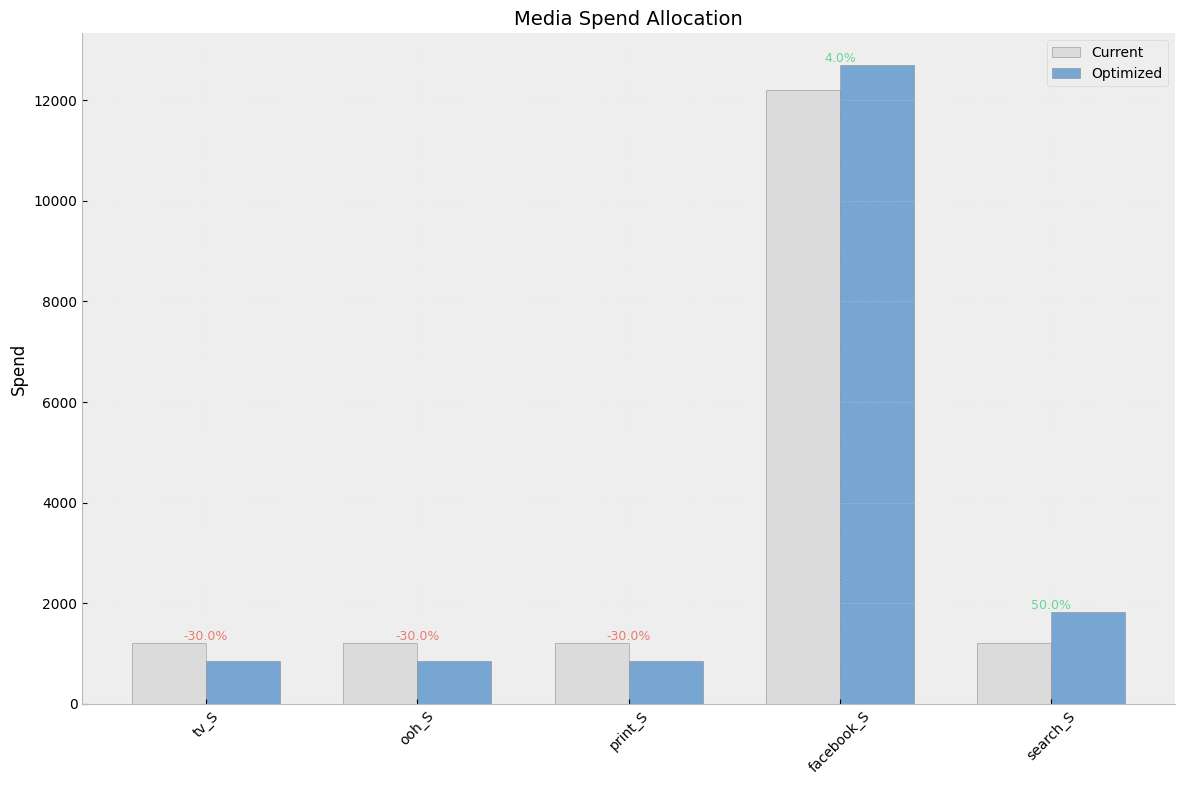

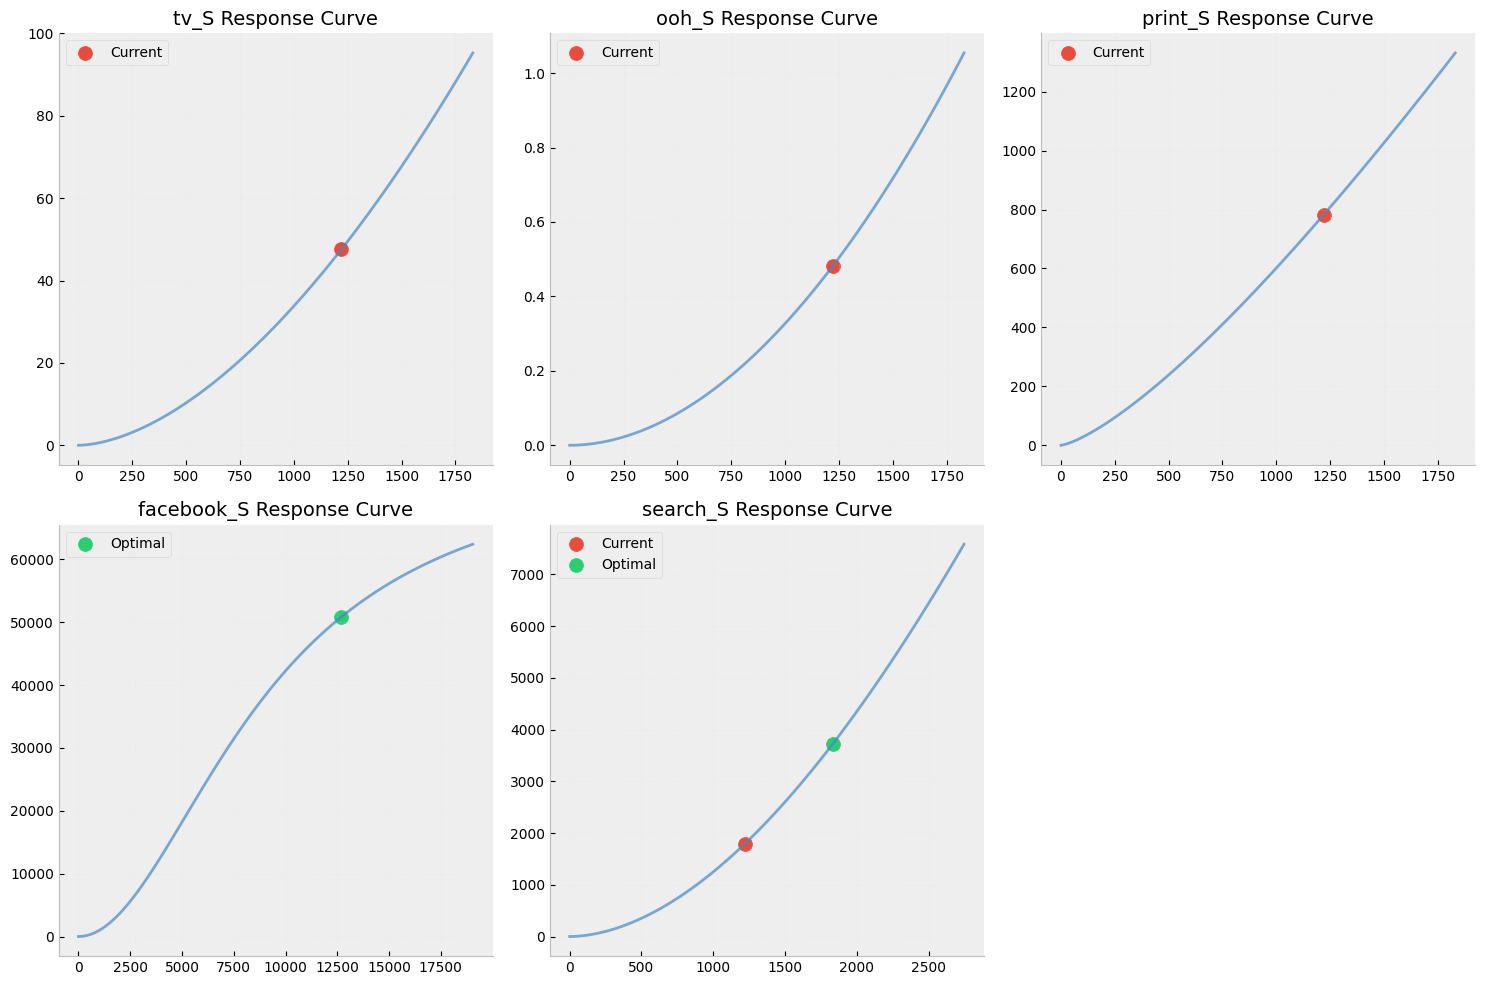

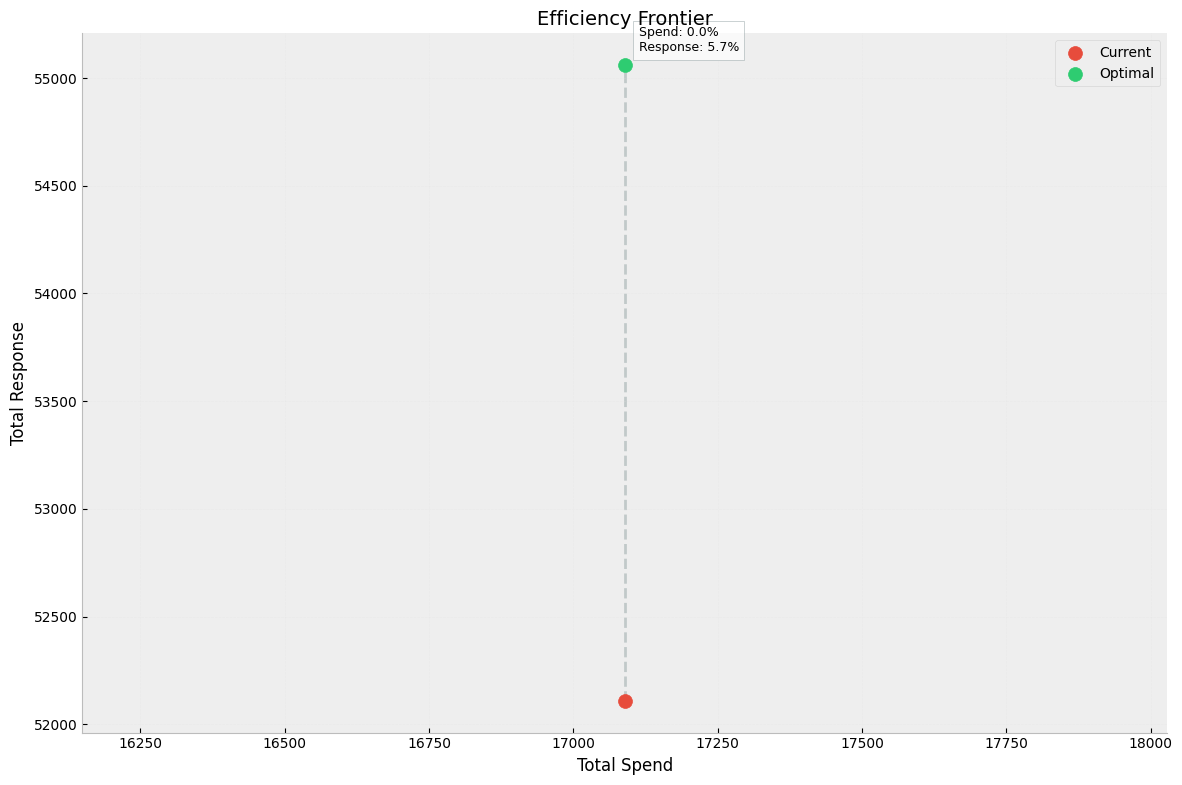

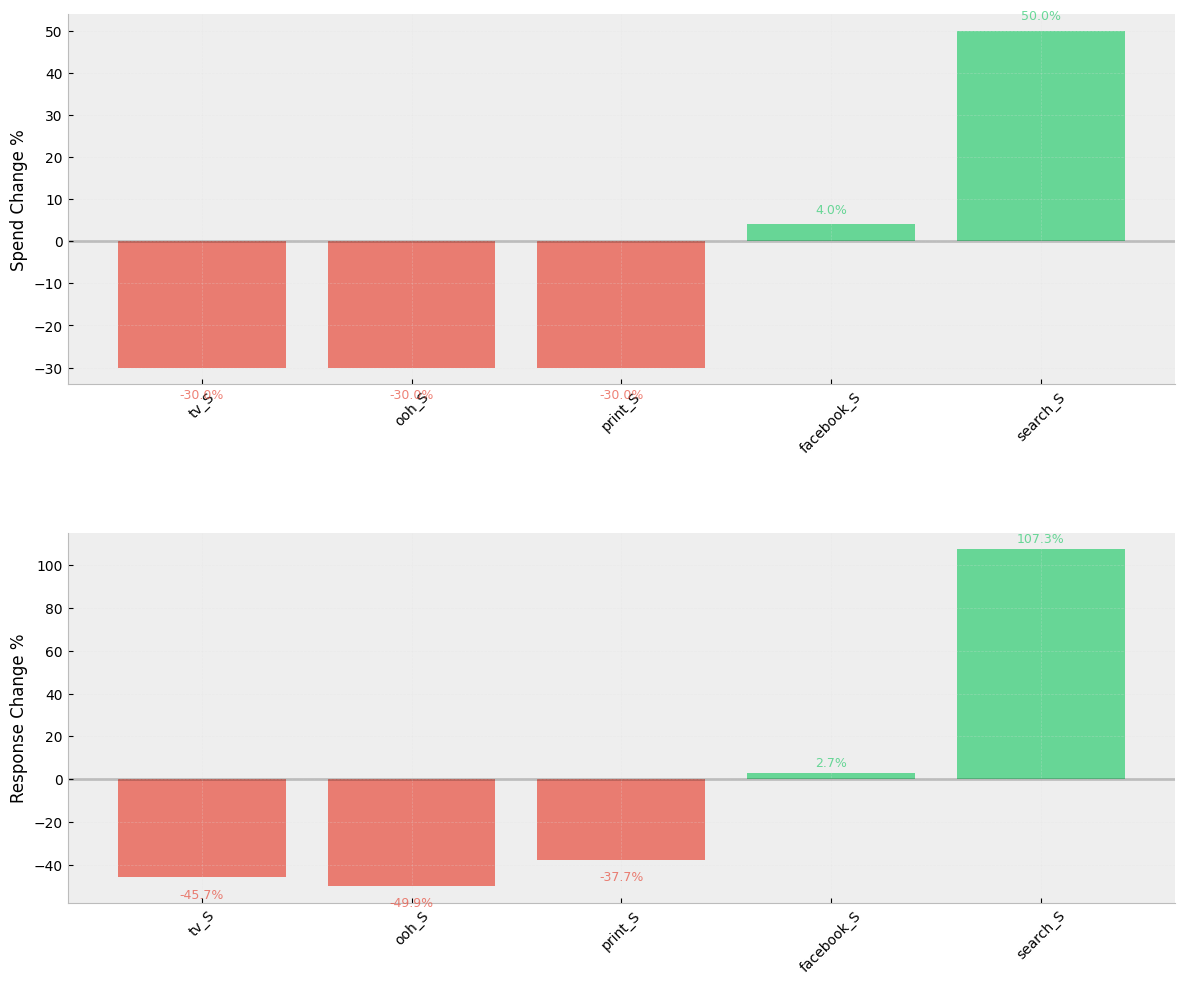

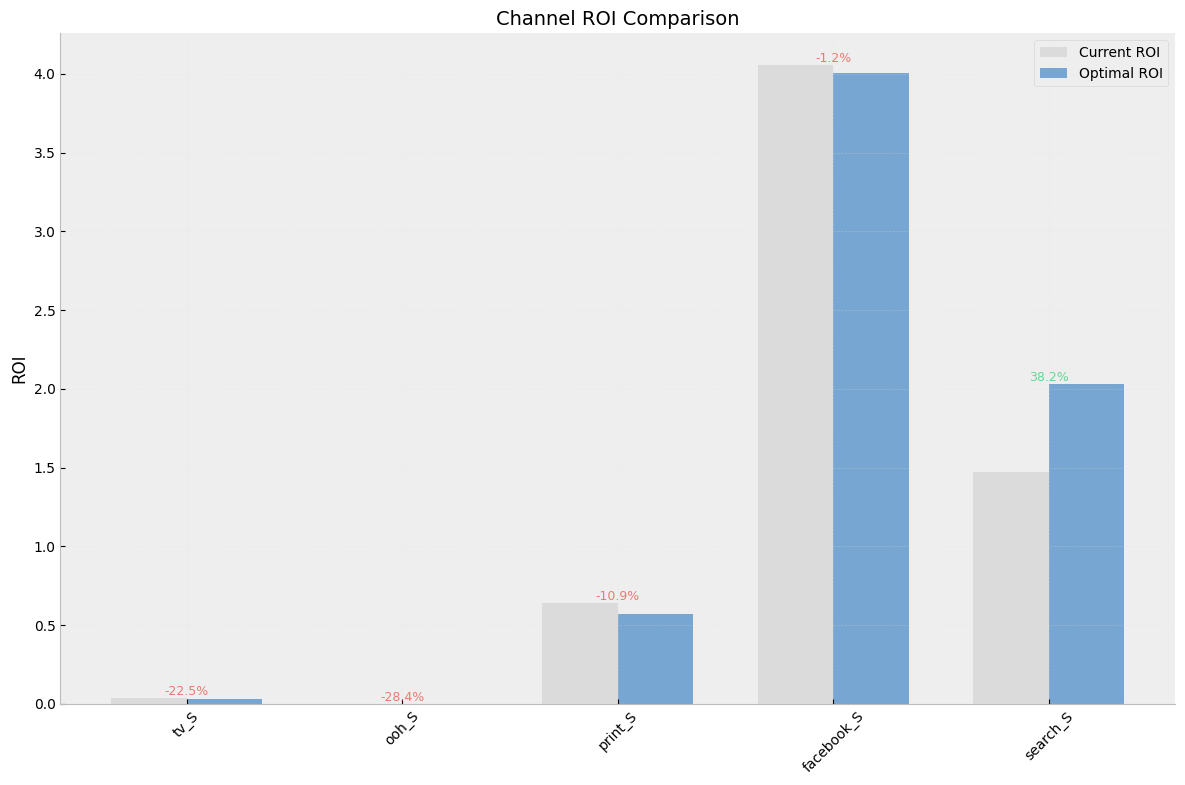


Target Efficiency Scenario Plots:
--------------------------------------------------


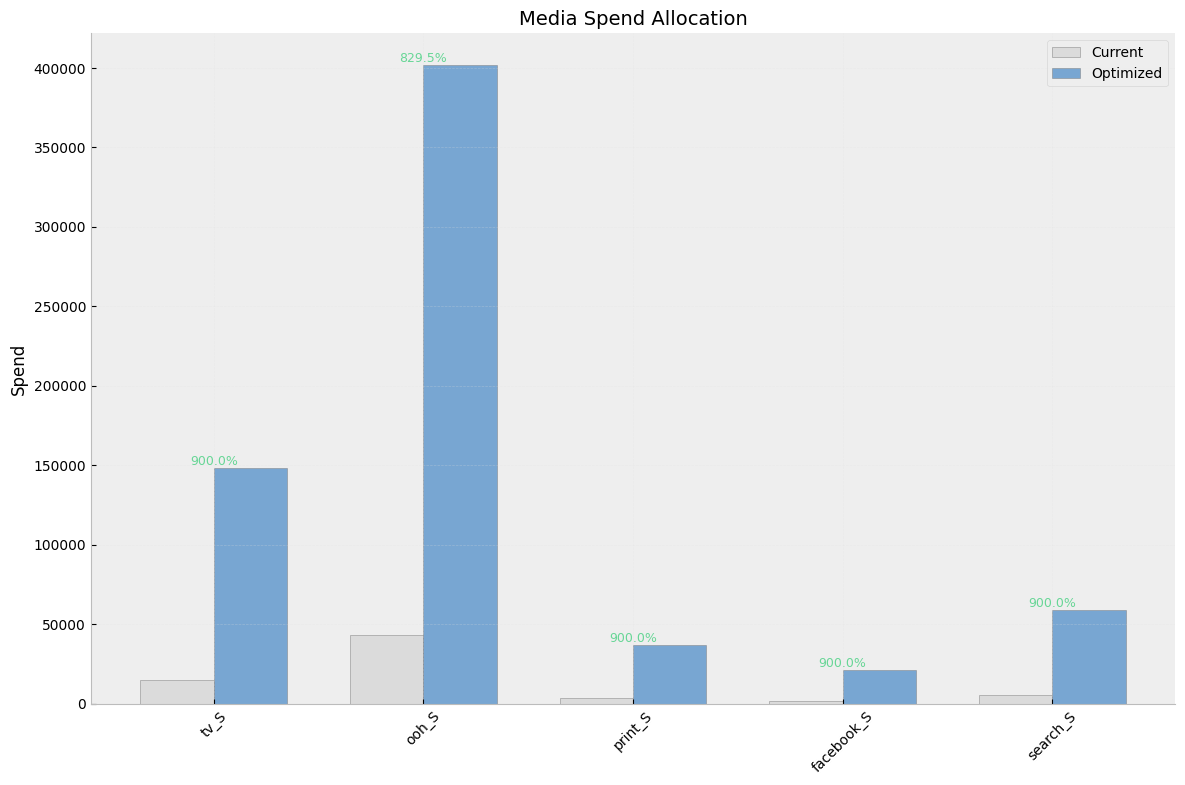

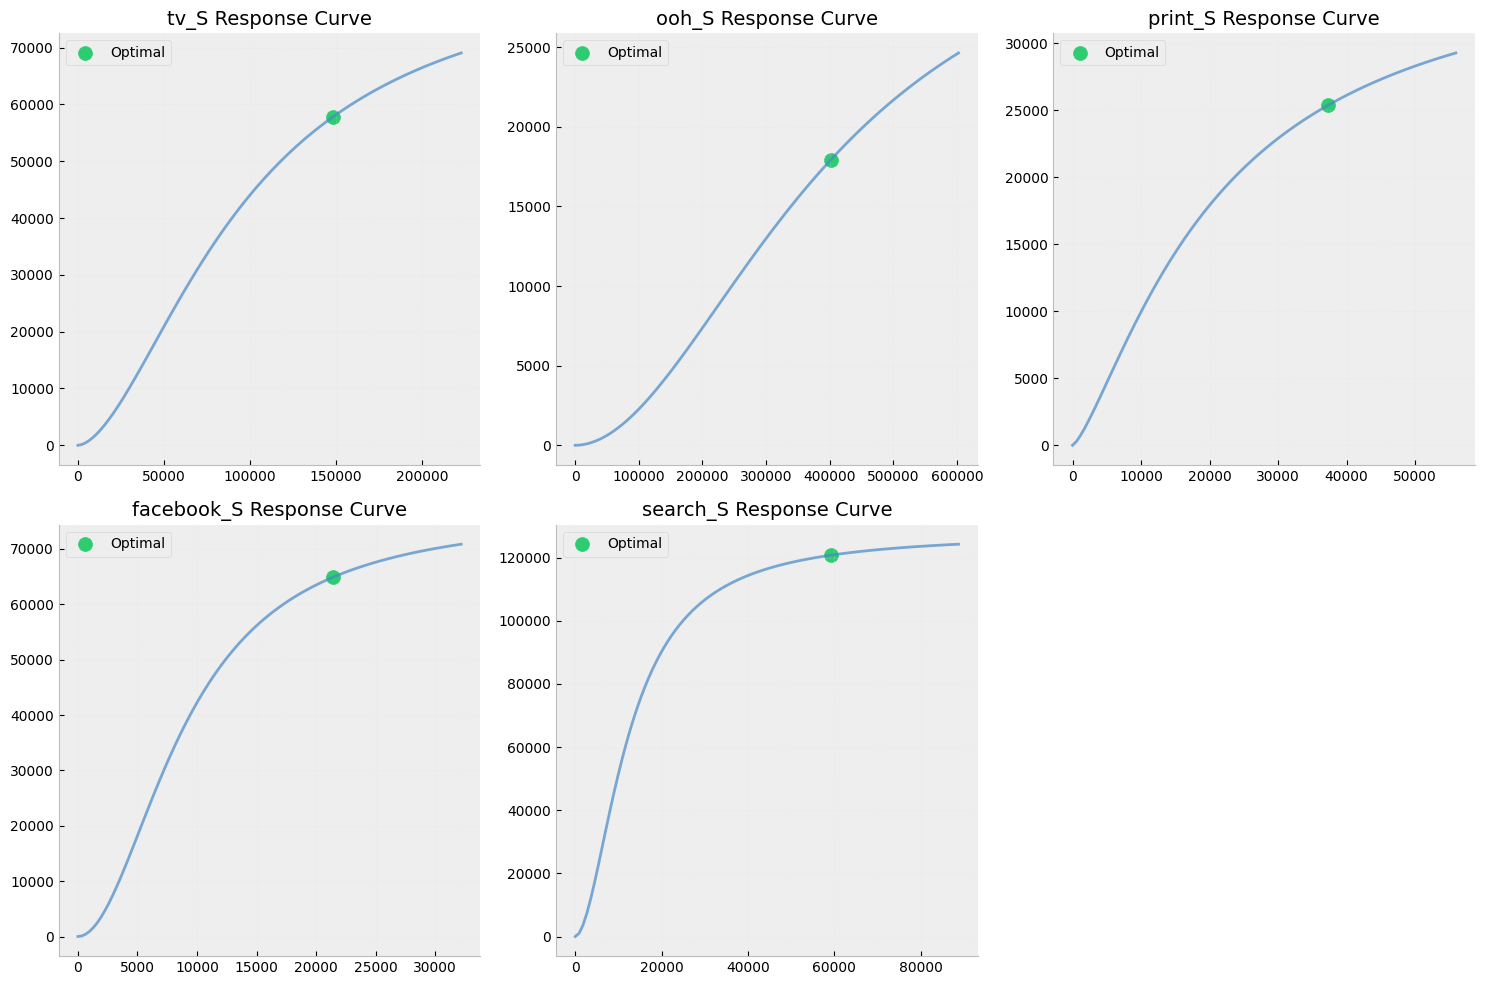

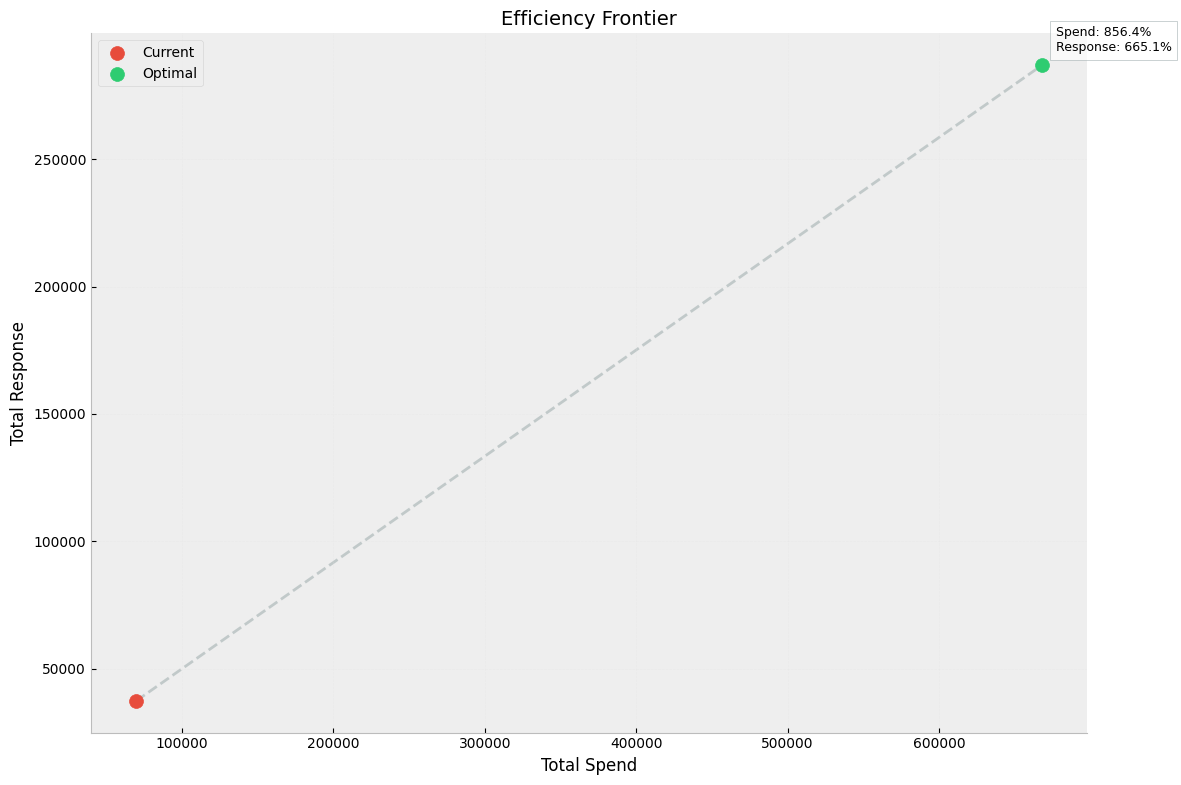

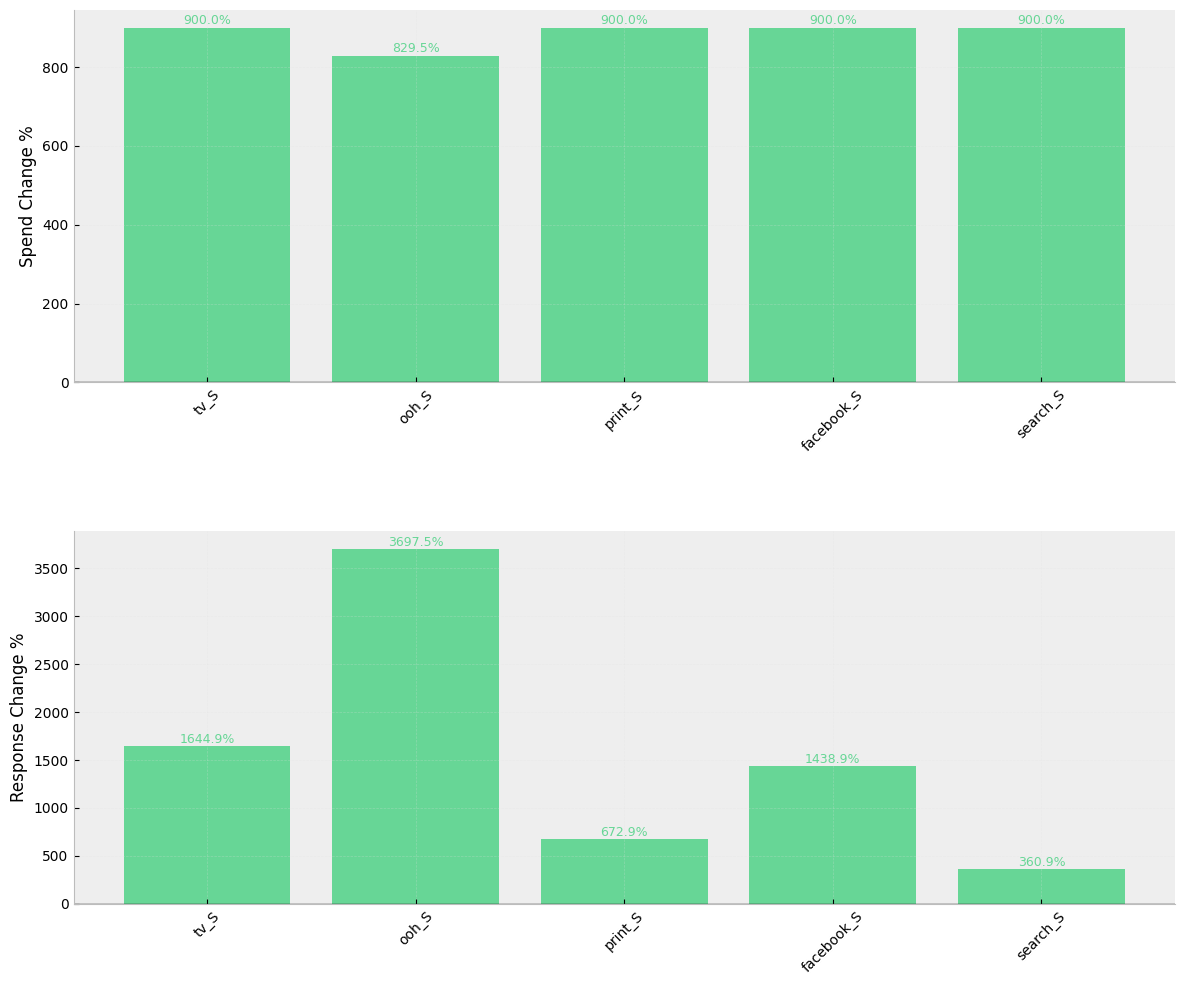

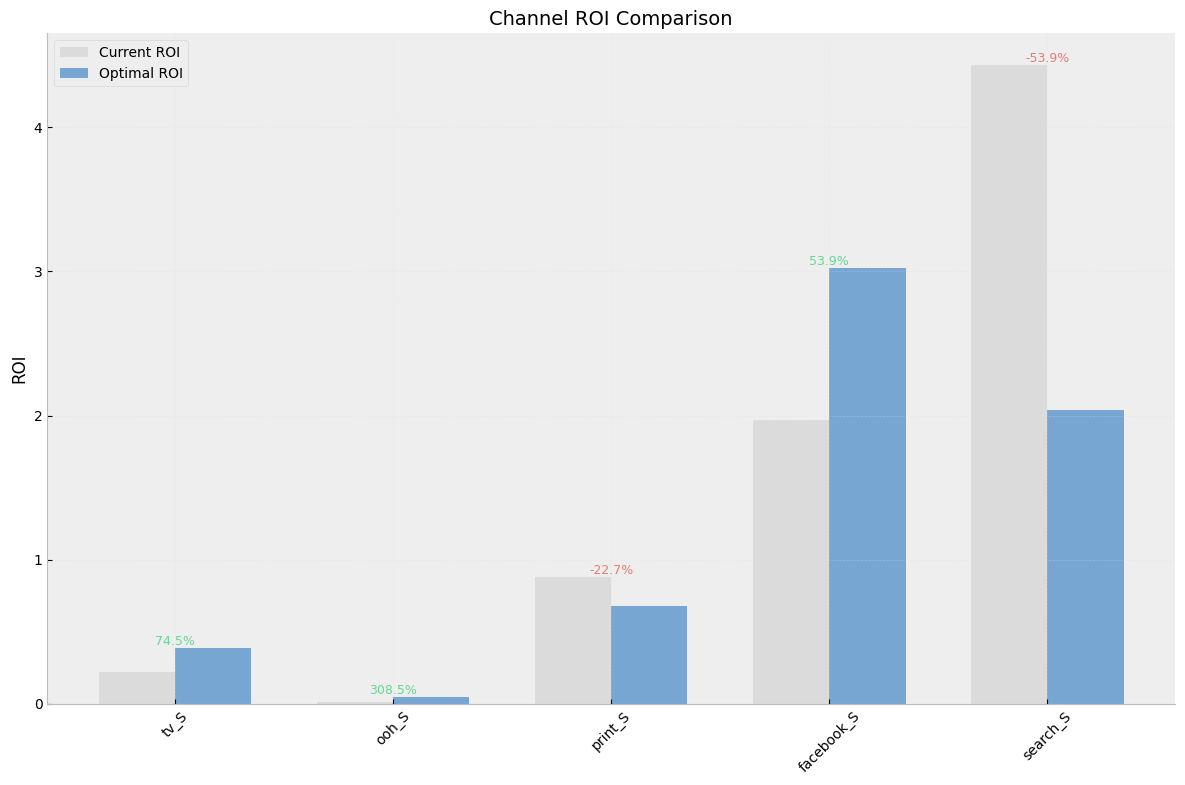

In [34]:
# Create visualizations for each scenario
max_response_plotter = AllocationPlotter(result)
target_efficiency_plotter = AllocationPlotter(result3)

# Generate plots
max_response_plots = max_response_plotter.plot_all()
target_efficiency_plots = target_efficiency_plotter.plot_all()

# Display plots
print("Max Response Scenario Plots:")
print("-" * 50)
for plot_name, fig in max_response_plots.items():
    display(fig)


print("\nTarget Efficiency Scenario Plots:")
print("-" * 50)
for plot_name, fig in target_efficiency_plots.items():
    display(fig)